In [2]:
from selenium import webdriver
from datetime import datetime
from html.parser import HTMLParser as ht
from html.entities import name2codepoint
import pandas as pd
import re

# Final Code

In [2]:
driver = webdriver.Chrome('./chromedriver_win32/chromedriver.exe')

In [3]:
driver.get('https://www.goalzz.com/?region=-7&team=11')

In [56]:
all_archive = [x.text for x in driver.find_elements_by_xpath('.//tr[@data-match]')]

In [67]:
dates = [x.split('\n')[2] for x in all_archive ]

In [69]:
contests = [x.split('\n')[1] for x in all_archive ]

regex : r"(.+)(\d+) : (\d+)(.+)"

In [78]:
details = [x.split('\n')[3] for x in all_archive]

# Cleaning Data 

In [63]:
df_ = pd.read_csv('all_archive_goalzz_v3.csv')

In [5]:
details_col = df['details'].tolist()

In [6]:
regex_list = [re.match(r'(.+)(\d+) : (\d+)(.+)',x) for x in details_col]

In [7]:
home_team = [x.groups()[0].split('-')[0].strip() if '-' in x.groups()[0] else x.groups()[0].strip() for x in regex_list]

In [35]:
away_team = [x.groups()[3].strip() for x in regex_list]

In [37]:
final_away_team = []
for away in away_team:
    tmp_away = ' '.join(away.split(' ')[:3]).strip()
    final_away_team.append(tmp_away)
    for home in home_team:
        if home in away:
            final_away_team.pop()
            final_away_team.append(home)
            break

In [38]:
score_home = [x.groups()[1] for x in regex_list]

In [39]:
score_away = [x.groups()[2] for x in regex_list]

In [40]:
def cast_date(str_):
    tmp_str = str_
    if len(str_) < 8:
        tmp_str = '2020/'+ tmp_str
    return datetime.strptime(tmp_str,"%Y/%m/%d")

In [41]:
df['home_team'] = home_team

In [42]:
df['away_team'] = final_away_team

In [43]:
df['home_score'] = score_home

In [44]:
df['home_score'] = df['home_score'].astype('int')

In [45]:
df['away_score'] = score_away

In [46]:
df['away_score'] = df['away_score'].astype('int')

In [47]:
df['date_match'] = df['date'].apply(cast_date) 

In [48]:
def at_anfield(row):
    if 'Liverpool'in row['home_team'] :
        return True
    else :
        return False

In [49]:
df['at_anfield'] = df.apply(at_anfield,axis=1)

In [50]:
def score_final(row):
    if row['home_score'] == row['away_score']:
        return 'N'
    elif (row['home_score'] > row['away_score'] and row['at_anfield']) | (row['home_score'] < row['away_score'] and not row['at_anfield']):
        return 'V'
    else : 
        return 'D'

In [51]:
df['liverpool_score'] = df.apply(score_final,axis=1)

In [52]:
start_date = datetime(2012,8,17)

In [53]:
rest = [0]
for i in range(1,len(df)):
    rest.append((df['date_match'][i] - df['date_match'][i-1] ).days)

In [54]:
df['rest_days'] = rest

In [55]:
def get_season(date):
    current_year = date.year
    month = date.month
    if month < 8:
        past_year = current_year - 1
        return str(past_year) + ' - ' + str(current_year)
    else :
        next_year = current_year + 1
        return str(current_year) + ' - ' + str(next_year)

In [56]:
df['season'] = df['date_match'].apply(get_season)

In [57]:
df_final = df[['date_match','contests', 'home_team', 'home_score',  
       'away_score', 'away_team', 'liverpool_score','at_anfield','season',
       'rest_days']]

In [58]:
date_filter = df_final['date_match'] > start_date

In [59]:
df_final = df_final[date_filter]

In [73]:
df_final.to_csv('goalzz_archive_from_2012_v2.csv',index=False)

In [186]:
df = df[df_final.columns]

In [187]:
df.to_csv('all_archive_goalzz_v4.csv',index=False)

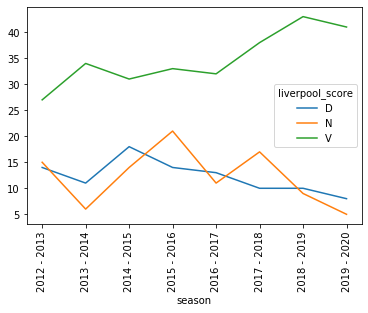

In [181]:
df_final.groupby(['season','liverpool_score']).count()['date_match'].unstack().plot(rot = 90)